# Kaggle competition restaurant visitor forecasting competition
https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# format notebook output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.core.display import display, HTML, Javascript
display(HTML("<style>.container { width:90% !important; }</style>"))

# style pandas display
pd.set_option('display.max_columns', None)

# matplotlib magic
%matplotlib inline

In [2]:
def desc(df):
    display(df.head())
    print(df.shape)
    print(df.dtypes)

# Load data

In [4]:
air_reserve = pd.read_csv('../../data_files/air_reserve.csv')
air_store_info = pd.read_csv('../../data_files/air_store_info.csv', encoding='utf-8')
air_visit_data = pd.read_csv('../../data_files/air_visit_data.csv')
date_info = pd.read_csv('../../data_files/date_info.csv')
hpg_reserve = pd.read_csv('../../data_files/hpg_reserve.csv')
hpg_store_info = pd.read_csv('../../data_files/hpg_store_info.csv')
sample_submission = pd.read_csv('../../data_files/sample_submission.csv')
store_id_relation = pd.read_csv('../../data_files/store_id_relation.csv')
expanded_date_info = pd.read_csv('../../data_files/expanded_date_info.csv')

# Effect of holidays on total numbers

## Actual visits

In [9]:
air_visit_data = pd.merge(
    left=air_visit_data,
    right=expanded_date_info.rename(columns={'calendar_date': 'visit_date'}),
    on='visit_date',
    how='left',
    copy=False
)

In [11]:
desc(air_visit_data)

,air_store_id,visit_date,visitors,day_of_week,holiday_flg
0,air_ba937bf13d40fb24,2016-01-13,25,Wednesday,0
1,air_ba937bf13d40fb24,2016-01-14,32,Thursday,0
2,air_ba937bf13d40fb24,2016-01-15,29,Friday,0
3,air_ba937bf13d40fb24,2016-01-16,22,Saturday,0
4,air_ba937bf13d40fb24,2016-01-18,6,Monday,0


(252108, 5)
air_store_id    object
visit_date      object
visitors         int64
day_of_week     object
holiday_flg      int64
dtype: object


In [15]:
air_visit_data['day_of_week'].isnull().sum()
air_visit_data['holiday_flg'].isnull().sum()

0

0

### Effect of total number of visitors to air restaurants on holidays

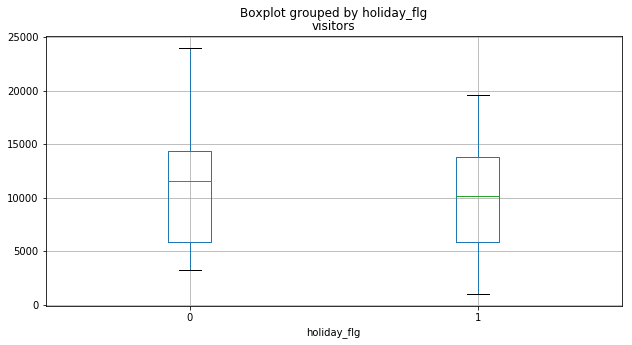

In [46]:
air_visit_data[[
    'visit_date',
    'visitors',
    'holiday_flg'
]].groupby('visit_date', as_index=False).agg({
    'visitors': 'sum',
    'holiday_flg': 'max'
}).boxplot(
    column='visitors',
    by='holiday_flg',
    figsize=(10, 5)
);

## Reservations

In [31]:
air_reserve['visit_date'] = air_reserve['visit_datetime'].apply(lambda x: x[:10])

In [35]:
air_reserve = pd.merge(
    left=air_reserve,
    right=expanded_date_info.rename(columns={'calendar_date': 'visit_date'}),
    on='visit_date',
    how='left',
    copy=False
)

In [37]:
desc(air_reserve)

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,visit_date,day_of_week,holiday_flg
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1,2016-01-01,Friday,1
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3,2016-01-01,Friday,1
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6,2016-01-01,Friday,1
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2,2016-01-01,Friday,1
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5,2016-01-01,Friday,1


(92378, 7)
air_store_id        object
visit_datetime      object
reserve_datetime    object
reserve_visitors     int64
visit_date          object
day_of_week         object
holiday_flg          int64
dtype: object


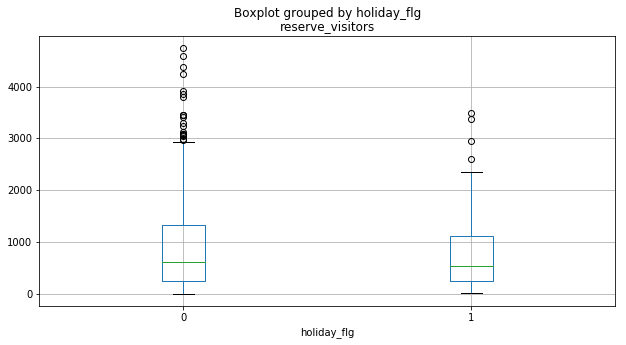

In [45]:
air_reserve[[
    'visit_date',
    'reserve_visitors',
    'holiday_flg'
]].groupby('visit_date', as_index=False).agg({
    'reserve_visitors': 'sum',
    'holiday_flg': 'max'
}).boxplot(
    column='reserve_visitors',
    by='holiday_flg',
    figsize=(10, 5)
);

# Effect of day of week on total numbers

## Actual visits

In [40]:
air_visit_data.head()

,air_store_id,visit_date,visitors,day_of_week,holiday_flg
0,air_ba937bf13d40fb24,2016-01-13,25,Wednesday,0
1,air_ba937bf13d40fb24,2016-01-14,32,Thursday,0
2,air_ba937bf13d40fb24,2016-01-15,29,Friday,0
3,air_ba937bf13d40fb24,2016-01-16,22,Saturday,0
4,air_ba937bf13d40fb24,2016-01-18,6,Monday,0


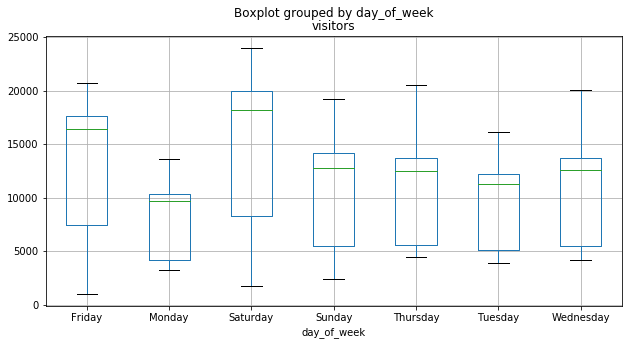

In [44]:
air_visit_data[[
    'visit_date',
    'visitors',
    'day_of_week'
]].groupby('visit_date', as_index=False).agg({
    'visitors': 'sum',
    'day_of_week': 'max'
}).boxplot(
    column='visitors',
    by='day_of_week',
    figsize=(10, 5)
);

## Reservations

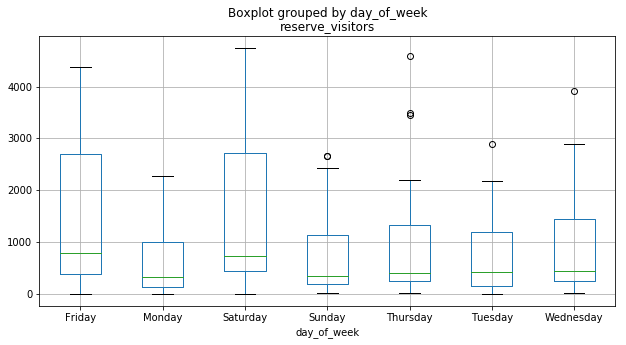

In [50]:
air_reserve[[
    'visit_date',
    'reserve_visitors',
    'day_of_week'
]].groupby('visit_date', as_index=False).agg({
    'reserve_visitors': 'sum',
    'day_of_week': 'max'
}).boxplot(
    column='reserve_visitors',
    by='day_of_week',
    figsize=(10, 5)
);

## Weekday and holiday

### Visits

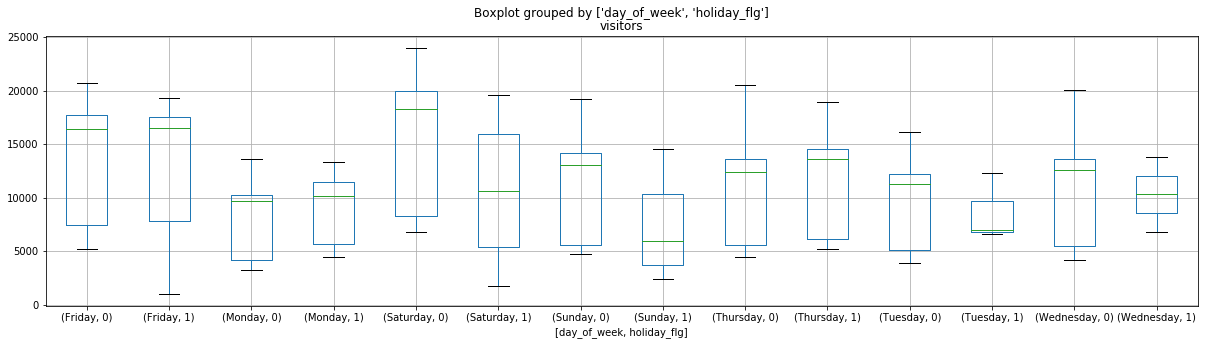

In [49]:
air_visit_data[[
    'visit_date',
    'visitors',
    'day_of_week',
    'holiday_flg'
]].groupby('visit_date', as_index=False).agg({
    'visitors': 'sum',
    'day_of_week': 'max',
    'holiday_flg': 'max'
}).boxplot(
    column='visitors',
    by=['day_of_week', 'holiday_flg'],
    figsize=(20, 5)
);

### Reservations

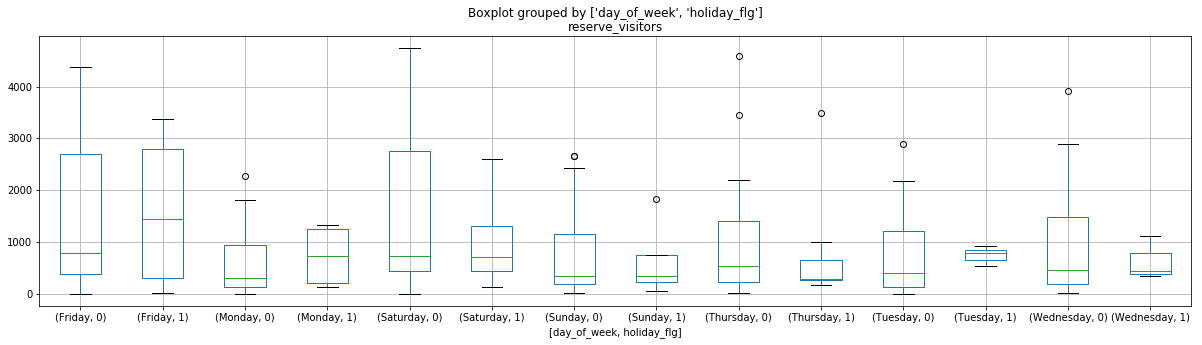

In [52]:
air_reserve[[
    'visit_date',
    'reserve_visitors',
    'day_of_week',
    'holiday_flg'
]].groupby('visit_date', as_index=False).agg({
    'reserve_visitors': 'sum',
    'day_of_week': 'max',
    'holiday_flg': 'max'
}).boxplot(
    column='reserve_visitors',
    by=['day_of_week', 'holiday_flg'],
    figsize=(20, 5)
);

Break down effects by
- area
- genre
- location (plot difference in medians)

In [55]:
air_visit_data = pd.merge(
    left=air_visit_data,
    right=air_store_info[[
        'air_store_id',
        'air_genre_name',
        'air_area_name'
    ]],
    on='air_store_id',
    how='left',
    copy=False
)

In [56]:
desc(air_visit_data)

,air_store_id,visit_date,visitors,day_of_week,holiday_flg,air_genre_name,air_area_name
0,air_ba937bf13d40fb24,2016-01-13,25,Wednesday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen
1,air_ba937bf13d40fb24,2016-01-14,32,Thursday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen
2,air_ba937bf13d40fb24,2016-01-15,29,Friday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen
3,air_ba937bf13d40fb24,2016-01-16,22,Saturday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen
4,air_ba937bf13d40fb24,2016-01-18,6,Monday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen


(252108, 7)
air_store_id      object
visit_date        object
visitors           int64
day_of_week       object
holiday_flg        int64
air_genre_name    object
air_area_name     object
dtype: object


In [58]:
air_visit_data['air_genre_name'].value_counts()

Izakaya                         62052
Cafe/Sweets                     52764
Dining bar                      34192
Italian/French                  30011
Bar/Cocktail                    25135
Japanese food                   18789
Other                            8246
Yakiniku/Korean food             7025
Western food                     4897
Creative cuisine                 3868
Okonomiyaki/Monja/Teppanyaki     3706
Asian                             535
Karaoke/Party                     516
International cuisine             372
Name: air_genre_name, dtype: int64

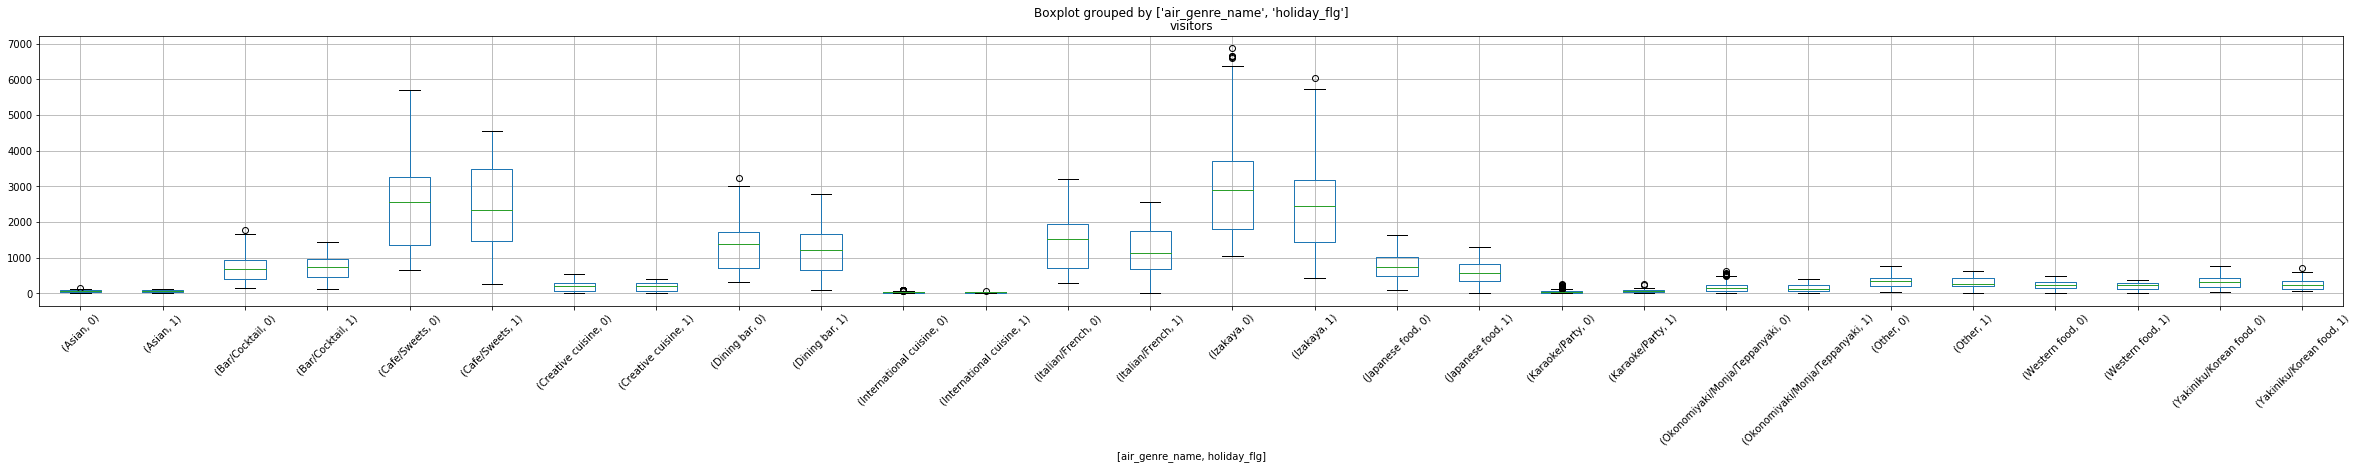

In [65]:
air_visit_data[[
    'visit_date',
    'visitors',
    'air_genre_name',
    'holiday_flg'
]].groupby(['visit_date', 'air_genre_name'], as_index=False).agg({
    'visitors': 'sum',
#     'air_genre_name': 'max',
    'holiday_flg': 'max'
}).boxplot(
    column='visitors',
    by=['air_genre_name', 'holiday_flg'],
    figsize=(40, 5),
    rot=45
);